In [1]:
import numpy as np
from scipy.special import hermite
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as functional

import matplotlib.pyplot as plt



import scipy.stats

In [3]:

class BlackScholesModel:
    def __init__(self, size, r, rho, sigma, divid, spot):
        self.size = size
        self.r = r
        self.rho = rho
        self.sigma = sigma
        self.divid = divid
        self.spot = spot
        self.cholesky = np.linalg.cholesky(
            np.eye(size) + rho * (np.ones((size, size)) - np.eye(size))
        )


    def asset(self, T, dates):
        """Generates paths for the asset prices based on the Black-Scholes model."""

        time_step = T / dates
        gaussian = np.random.normal(size=(dates+1, self.size))
        path = np.zeros((dates+1, self.size))
        path[0] = self.spot
        expo = np.exp((self.r - self.divid - np.square(self.sigma) / 2) * time_step)
        for i in range(1, dates + 1):
            for d in range(self.size):
                scale_cholesky_gaussian = np.dot(self.cholesky[d, :], gaussian[i])
                computed_share = path[i - 1, d] * expo[d] * np.exp(self.sigma[d] * np.sqrt(time_step) * scale_cholesky_gaussian)
                path[i, d] = computed_share
        return path


    def asset_conditionally(self, T, dates, n, stocks):
        """"Generates paths for the asset prices based on the Black-Scholes model, conditional on the current stock prices at time n."""
        gaussian = np.random.normal(size=(dates+1-n, self.size))
        path = np.zeros((dates + 1 - n, self.size))
        path[0] = stocks
        for i in range(n + 1, dates + 1):
            time_step = (i - n) * T / float(dates)
            expo = np.exp((self.r - self.divid - np.square(self.sigma) / 2) * time_step)
            for d in range(self.size):
                scale_cholesky_gaussian = np.dot(self.cholesky[d, :], gaussian[i - n])
                computed_share = stocks[d] * expo[d] * np.exp(self.sigma[d] * np.sqrt(time_step) * scale_cholesky_gaussian)
                path[i - n, d] = computed_share
        return path



class Max_call_option:
    def __init__(self, T, dates, size, strike):
        self.T = T
        self.dates = dates
        self.size = size
        self.strike = strike

    def payoff(self, pricesAt, n, r):
        price = max(pricesAt)
        payoff = price - self.strike
        return np.exp(-r * n  * self.T / float(self.dates)) * payoff if payoff > 0 else 0


        

Now that the asset model has been defined, the next step consists of defining a neural network architecture, optimizing the weights and training the network.

In [32]:
class NeuralNet(torch.nn.Module):
    def __init__(self, d, q1, q2):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(d, q1),
            nn.ReLU(),
            nn.Linear(q1, q2),
            nn.ReLU(),
            nn.Linear(q2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        propagation = self.net(x)
        return propagation


class Neural_Network_Pricer:
    def __init__(self, mod, opt, nb_samples, epochs=100):
        self.mod = mod
        self.opt = opt
        self.nb_samples = nb_samples
        #self.network = network
        self.epochs = epochs


    def simulate_samples(self, rounds):
        samples = []
        for _ in range(rounds):
            path = self.mod.asset(self.opt.T, self.opt.dates)
            samples.append(path)
        fitted = np.stack([samples[round] for round in range(len(samples))], axis=1)
        return torch.FloatTensor(fitted)
    
        

    def simulate_conditionally(self, n, samples, J):
        z_n = []
        for stocks in samples[n]:
            all_continuations = []
            for _ in range(J):
                continuation = self.mod.asset_conditionally(self.opt.T, self.opt.dates, n, stocks)
                all_continuations.append(continuation)
            z_n.append(all_continuations)
        return np.array(z_n)




    def initiate_values(self, samples):
        """Initiates the option values at date N before backward computing"""
        values = np.zeros((self.opt.dates + 1, self.nb_samples))
        for round in range(len(samples)):
            values[self.opt.dates, round] = self.opt.payoff(samples[self.opt.dates][round], self.opt.dates, self.mod.r)
        return values



    def train(self, samples):
        """Trains the neural network models for the optimal stopping problem, using the input samples."""
        f = np.zeros((self.opt.dates + 1, self.nb_samples))
        stopping = np.array([self.opt.dates for _ in range(self.nb_samples)])
        f[self.opt.dates, :] = 1
        trained_models = [None] * self.opt.dates
        losses = []
        for n in range(self.opt.dates - 1, -1, -1):
            neural_network = NeuralNet(self.mod.size, self.mod.size + 40, self.mod.size + 40)
            optimizer = torch.optim.Adam(neural_network.parameters(), lr = 0.0001)
            for epoch in range(self.epochs):
                F = neural_network.forward(samples[n])
                optimizer.zero_grad()
                reward = torch.zeros((self.nb_samples))
                for round in range(self.nb_samples):
                    reward[round] = -self.opt.payoff(samples[n][round], n, self.mod.r) * F[round] - self.opt.payoff(samples[int(stopping[round])][round], stopping[round], self.mod.r) * (1 - F[round])
                back_propagation_reward = reward.mean()
                back_propagation_reward.backward()
                optimizer.step() 
            trained_models[n] = neural_network
            adjusted_F = F.detach().numpy().reshape(self.nb_samples)
            f[n, :] = (adjusted_F > 0.5).astype(float)
            stopping = np.array([max(range(len(f[:,col])), key=lambda row: f[row,col]) for col in range(f.shape[1])])
            losses.append((np.min(adjusted_F) + np.max(adjusted_F))/2)
            print('n = {}, losses : {}'.format(n, losses[-1]))
        #plt.plot(losses[1:])
        #plt.title("Training Loss Over Time")
        #plt.xlabel("Dates")
        #plt.ylabel("Loss")
        #plt.show()
        return trained_models

      


Learning and loss computing has been establish. Next step : computing the lower bound, the upper bound and the point estimate for a trained neural network pricer.

In [21]:

def predict_values(pricer, samples, trained_models):
        """ Computes the predicted mean of all simulated payoffs at corresponding stopping times. Useful for lower bound."""
        f = np.zeros((pricer.opt.dates + 1, len(samples[0])))
        stopping = np.array([pricer.opt.dates for _ in range(len(samples[0]))])
        f[pricer.opt.dates, :] = 1
        values = pricer.initiate_values(samples)
        for n in range(pricer.opt.dates - 1, -1, -1):
            network = trained_models[n]
            F = network(samples[n])
            adjusted_F = F.detach().numpy().reshape(len(samples[0]))
            f[n, :] = (adjusted_F > 0.5).astype(float)
            stopping = np.array([max(range(len(f[:,col])), key=lambda row: f[row,col]) for col in range(f.shape[1])])
            for round in range(len(samples[0])):
                values[n, round] = np.exp((pricer.mod.r * pricer.opt.T / float(pricer.opt.dates)) * (stopping[round] - n)) * pricer.opt.payoff(samples[int(stopping[round])][round], stopping[round], pricer.mod.r)
        return values, f
    

def compute_lower_bound(pricer, trained_models):
    """ Uses the predicted mean of all simulated payoffs at corresponding stopping times to compute the lower bound."""
    samples = pricer.simulate_samples(pricer.nb_samples)
    values = predict_values(pricer, samples, trained_models)[0]
    lower_bound = np.mean(values, axis=1)
    return lower_bound[0]



def doob_increments(noise, doob):
    """Computes the incrementation for the doob matrix."""
    for i in range(len(doob)):
        for j in range(len(doob[0])):
            if i == 0:
                doob[i, j] = noise[i, j]
            else:
                doob[i, j] = doob[i - 1, j] + noise[i, j]

def get_proper_continuation(z_n, m, round, J):
    """Extracts the current conditionally simulated trajectory"""
    z_n_m = []
    for j in range(J):
        z_n_m.append(z_n[round][j][m])
    return torch.from_numpy(np.array(z_n_m)).float()




def compute_upper_bound(pricer, trained_models, Ku, J):
    """Computes the upper bound for the expected payoff using the Doob-Meyer decomposition."""
    z = pricer.simulate_samples(Ku)
    f = np.array([np.zeros((pricer.opt.dates + 1, J)) for _ in range(Ku)])
    f_theta = np.zeros((pricer.opt.dates + 1, Ku)) 
    stopping = np.array([np.zeros((pricer.opt.dates + 1, J)) for _ in range(Ku)])
    for round in range(Ku):
        f[round][pricer.opt.dates, :] = 1
        stopping[round][pricer.opt.dates, :] = pricer.opt.dates
    f_theta[pricer.opt.dates, :] = 1
    noisy_estimates = np.zeros((pricer.opt.dates + 1, Ku))
    doob = np.zeros((pricer.opt.dates + 1, Ku))
    z_N = pricer.simulate_conditionally(pricer.opt.dates, z, J)
    current_C = torch.from_numpy(np.array([np.mean(np.array([pricer.opt.payoff(z_N[round][j][-1], pricer.opt.dates, pricer.mod.r) for j in range(J)])) for round in range(Ku)]))
    
    for n in range(pricer.opt.dates - 1, -1, -1):
        z_n = pricer.simulate_conditionally(n, z, J)
        #fitted_z_n = torch.from_numpy(np.stack([z_n[round] for round in range(len(z_n))], axis=1))
        network = trained_models[n]
        F = network(z[n])
        adjusted_F = F.detach().numpy().reshape(Ku)
        f_theta = np.zeros((pricer.opt.dates + 1, Ku))
        f_theta[n, :] = (adjusted_F > 0.5).astype(float)
        for m in range(n, pricer.opt.dates):
            network = trained_models[m]
            for round in range(Ku):
                z_n_m = get_proper_continuation(z_n, m - n, round, J)
                F = network(z_n_m)
                adjusted_F = F.detach().numpy().reshape(J)
                f[round][m, :] = (adjusted_F > 0.5).astype(float)
                stopping[round][m, :] = np.array([max(range(len(f[round][:,col])), key=lambda row: f[round][row,col]) for col in range(f[round].shape[1])])
        previous_C = current_C
        current_C = torch.from_numpy(np.array([np.mean(np.array([pricer.opt.payoff(z_n[round][j][int(stopping[round][n + 1, j]) - n], stopping[round][n + 1, j], pricer.mod.r) for j in range(J)])) for round in range(Ku)]))
        for round in range(Ku):
            noisy_estimates[n + 1, round] = f_theta[n + 1, round] * pricer.opt.payoff(z[n + 1][round], n + 1, pricer.mod.r)  + (1 - f_theta[n + 1, round]) * previous_C[round] - current_C[round]
    
    doob_increments(noisy_estimates, doob)
    upper = np.array([[pricer.opt.payoff(z[n][round], n, pricer.mod.r) - doob[n, round] for round in range(Ku)] for n in range(pricer.opt.dates + 1)])
    maxed_upper = np.amax(upper, axis=0)
    return np.mean(maxed_upper)


## Model definition


n = 8, losses : 0.2618435025215149
n = 7, losses : 0.0004111065936740488
n = 6, losses : 0.4948141872882843
n = 5, losses : 0.45254191756248474
n = 4, losses : 0.002587599214166403
n = 3, losses : 0.024152621626853943
n = 2, losses : 0.020068170502781868
n = 1, losses : 0.015693658962845802
n = 0, losses : 0.002867746166884899


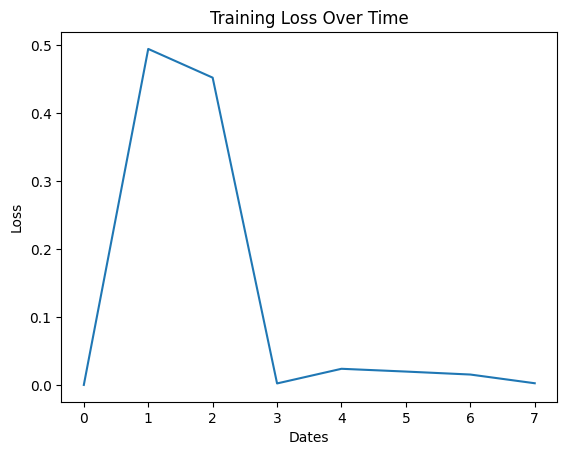

In [35]:

    

# Model parameters
T = 3
dates = 9

size = 2
r = 0.05
rho = 0
strike = 100
sigma = np.array(size * [0.2])
divid = np.array(size * [0.1])
spot = np.array(size * [90])

model = BlackScholesModel(size, r, rho, sigma, divid, spot)
option = Max_call_option(T, dates, size, strike)

nb_samples = 1000

epochs = 100

# Instantiate neural network
pricer = Neural_Network_Pricer(model, option, nb_samples, epochs)
training_samples = pricer.simulate_samples(pricer.nb_samples)
trained_models = pricer.train(training_samples)


The model is now trained. 

In [11]:
Ku = 1024
J = 10

lower_bound = compute_lower_bound(pricer, trained_models)

upper_bound = compute_upper_bound(pricer, trained_models, Ku, J)

print(lower_bound, upper_bound, (lower_bound + upper_bound)/2)

5.307470426440239 7.525725878721344 6.416598152580791


## Testing + resetting

Several test cases will be generated, while comparing them to the article's results.

In [ ]:
Ku = 1024
J = 10
nb_samples = 1000

r = 0.05
rho = 0
strike = 100
sizes = [2, 3, 5, 10]

spot_list = [90, 100, 110]

epochs = 50

results = {}
for size in sizes:
    sigma = np.array(size * [0.2])
    divid = np.array(size * [0.1])
    spot = np.array(size * [90])
    model = BlackScholesModel(size, r, rho, sigma, divid, spot)
    option = Max_call_option(T, dates, size, strike)
    # Instantiate neural network
    pricer = Neural_Network_Pricer(model, option, nb_samples, epochs)
    training_samples = pricer.simulate_samples(pricer.nb_samples)
    trained_models = pricer.train(training_samples)
    lower_bound = compute_lower_bound(pricer, trained_models)
    upper_bound = compute_upper_bound(pricer, trained_models, Ku, J)
    results[size] = (lower_bound, upper_bound, (lower_bound + upper_bound)/2)

print(results)



    

n = 8, losses : 0.5000083446502686
n = 7, losses : 0.5049995183944702
n = 6, losses : 0.0211415383964777
n = 5, losses : 0.49918392300605774
n = 4, losses : 0.4978744685649872
n = 3, losses : 0.3023494780063629
n = 2, losses : 0.00859603937715292
n = 1, losses : 1.662284012127202e-05
n = 0, losses : 0.0015441227005794644
n = 8, losses : 0.08373884856700897
n = 7, losses : 0.021322011947631836
n = 6, losses : 0.45088326930999756
n = 5, losses : 0.4972057044506073
n = 4, losses : 0.03288450092077255
n = 3, losses : 0.012143447063863277
n = 2, losses : 0.46778345108032227
n = 1, losses : 0.05023157224059105
n = 0, losses : 0.004437513183802366
n = 8, losses : 0.4994964897632599
n = 7, losses : 0.49942150712013245
n = 6, losses : 0.23826858401298523
n = 5, losses : 0.08523745834827423
n = 4, losses : 0.009950888343155384
n = 3, losses : 0.14806559681892395
n = 2, losses : 0.010606487281620502
n = 1, losses : 0.0004447714309208095
n = 0, losses : 1.5398244102016179e-07
n = 8, losses : 0.498

In [ ]:
Ku = 1024
J = 10
nb_samples = 1000

r = 0.05
rho = 0
strike = 100
sizes = [20, 30, 50]

spot_list = [90, 100, 110]

epochs = 50

results = {}
for size in sizes:
    sigma = np.array(size * [0.2])
    divid = np.array(size * [0.1])
    spot = np.array(size * [90])
    model = BlackScholesModel(size, r, rho, sigma, divid, spot)
    option = Max_call_option(T, dates, size, strike)
    # Instantiate neural network
    pricer = Neural_Network_Pricer(model, option, nb_samples, epochs)
    training_samples = pricer.simulate_samples(pricer.nb_samples)
    trained_models = pricer.train(training_samples)
    lower_bound = compute_lower_bound(pricer, trained_models)
    upper_bound = compute_upper_bound(pricer, trained_models, Ku, J)
    results[size] = (lower_bound, upper_bound, (lower_bound + upper_bound)/2)

print(results)

n = 8, losses : 0.033169180154800415
n = 7, losses : 0.4998258352279663
n = 6, losses : 0.4833296537399292
n = 5, losses : 1.5649405327167187e-08
n = 4, losses : 0.044039420783519745
n = 3, losses : 0.008321481756865978
n = 2, losses : 0.011700129136443138
n = 1, losses : 0.0005841527599841356
n = 0, losses : 0.00047164910938590765
n = 8, losses : 0.48578232526779175
n = 7, losses : 1.4796819414186757e-07
n = 6, losses : 0.00679620960727334
n = 5, losses : 0.4952402412891388
n = 4, losses : 0.0047157397493720055
n = 3, losses : 0.00013559250510297716
n = 2, losses : 0.0013486298266798258
n = 1, losses : 0.00041310160304419696
n = 0, losses : 0.00011968493345193565
n = 8, losses : 0.0007387041696347296
n = 7, losses : 0.006351165473461151
n = 6, losses : 0.0007318302523344755
n = 5, losses : 0.0007506207330152392
n = 4, losses : 3.479527367744595e-05
n = 3, losses : 0.0003611064166761935
n = 2, losses : 0.0001467321126256138
n = 1, losses : 0.0004859223263338208
n = 0, losses : 1.358863